# MCMC simulation of Coal mining disasters

## Imports

In [3]:
%matplotlib inline
from pymc3 import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [5]:
disaster_data = np.array([4,5,4,1,0,4,3,4,0,6,3,3,4,0,2,6,3,3,5,4,5,
                        3,1,4,4,1,5,5,3,4,2,5,2,2,3,4,2,1,3,2,2,1,
                        1,1,1,3,0,0,1,0,1,1,0,0,3,1,0,3,2,2,0,1,1,
                        1,0,1,0,1,0,0,0,2,1,0,0,0,1,1,0,2,3,3,1,1,
                        2,1,1,1,1,2,4,2,0,0,0,1,4,0,0,0,1,0,0,0,0,
                        0,1,0,0,1,0,1])
year = np.arange(1851, 1963)
print(np.shape(disaster_data), np.shape(year))

## Specify model

Y is the number of coal mining disasters in Britain, per year, between 1851–1962. It is argued that at some point in time, the rate of disasters should have decreased following the improvement of mining technology and the imposition of tougher safety regulations. 

Consider the following model for the number of occurrences $y_i$ of some event during time interval i:

$$ y_i \sim Poisson(\theta_{i})$$

$$ \theta_{i} = \begin{cases}
l \quad if \; i \leq \tau\\
e \quad if \; i > \tau
\end{cases}
$$

$$\tau \sim Uniform(t_l,t_h)$$

$$ e \sim exp(1)$$

$$ l \sim exp(1)$$

where $t_l$ is the first year and $t_h$ is the last year

In [37]:
from pymc3.math import switch

with Model() as model: # model specifications
    
    # The switchpoint
    tau = DiscreteUniform('switchpoint', lower=year.min(), upper=year.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = Exponential('early_rate', 1)
    late_rate = Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = switch(tau >= year, early_rate, late_rate)

    disasters = Poisson('disasters', rate, observed=disaster_data)

    start = find_MAP() # Find starting value by optimization
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(20000, step, start=start, progressbar=True, njobs=3) 
    # draw 20000 posterior samples, 3 chains.

Optimization terminated successfully.
         Current function value: 210.572536
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10


Assigned Metropolis to switchpoint
100%|██████████| 20000/20000 [01:09<00:00, 287.13it/s]


## Convergence

### Gelman rubin

In [38]:
gelman_rubin(trace)

{'early_rate': 1.000007582290166,
 'early_rate_log_': 1.0000052057861972,
 'late_rate': 1.0000305229307249,
 'late_rate_log_': 0.99999803170119816,
 'switchpoint': 1.0002186536282882}

$\approx$ 1. So we could have converged.

## Inference

In [39]:
trace_burnin = trace[5000:] # Apply burn in, 5000 samples.
df_summary(trace_burnin, varnames=['switchpoint', 'early_rate', 'late_rate'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
switchpoint,1890.063800,2.439425,0.031339,1885.000000,1895.000000
early_rate,3.062606,0.282920,0.001850,2.511543,3.618719
late_rate,0.923597,0.115309,0.001549,0.702450,1.149893


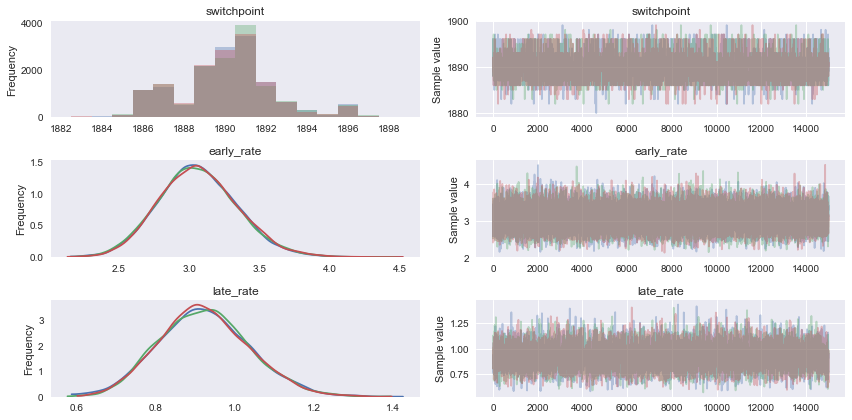

In [40]:
plt.figure(figsize=(3, 3))
traceplot(trace_burnin)
plt.tight_layout()

As seen in the difference in early reate and late rate there is some kind of switchpoint.
In the trace plot below we can see that there’s about a 10 year span that’s plausible for a significant change in safety, but a 5 year span that contains most of the probability mass. 